<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:13:39] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


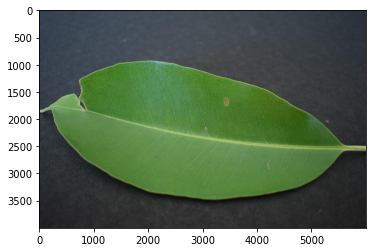

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

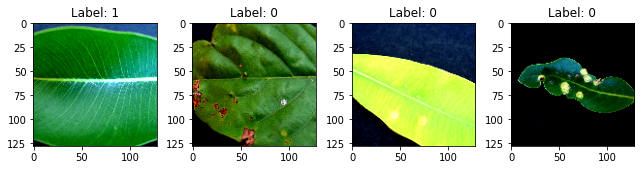

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:13:45] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:13:47] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2455402926391796 samples/sec                   batch loss = 0.27939164638519287 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.2613415337646414 samples/sec                   batch loss = 1.6324211359024048 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.256716628318464 samples/sec                   batch loss = 0.5210205316543579 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2602649955293732 samples/sec                   batch loss = 0.3081621527671814 | accuracy = 0.6625


Epoch[1] Batch[25] Speed: 1.2711358369621268 samples/sec                   batch loss = 3.2099173069000244 | accuracy = 0.64


Epoch[1] Batch[30] Speed: 1.269413099399736 samples/sec                   batch loss = 0.7398011684417725 | accuracy = 0.6416666666666667


Epoch[1] Batch[35] Speed: 1.2669589412265336 samples/sec                   batch loss = 0.6718546152114868 | accuracy = 0.6642857142857143


Epoch[1] Batch[40] Speed: 1.2716483077032457 samples/sec                   batch loss = 0.6456886529922485 | accuracy = 0.65625


Epoch[1] Batch[45] Speed: 1.2653864432298172 samples/sec                   batch loss = 0.6697691082954407 | accuracy = 0.65


Epoch[1] Batch[50] Speed: 1.2743330137097844 samples/sec                   batch loss = 0.7092053890228271 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.2827782829204977 samples/sec                   batch loss = 0.9079631567001343 | accuracy = 0.6272727272727273


Epoch[1] Batch[60] Speed: 1.261567269424423 samples/sec                   batch loss = 0.8489964008331299 | accuracy = 0.6333333333333333


Epoch[1] Batch[65] Speed: 1.2715455684854176 samples/sec                   batch loss = 0.9377184510231018 | accuracy = 0.6423076923076924


Epoch[1] Batch[70] Speed: 1.264615192810065 samples/sec                   batch loss = 1.691941261291504 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.2697259071154139 samples/sec                   batch loss = 0.7467021942138672 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.264213439462498 samples/sec                   batch loss = 0.27601662278175354 | accuracy = 0.653125


Epoch[1] Batch[85] Speed: 1.2623425938793613 samples/sec                   batch loss = 0.2761085629463196 | accuracy = 0.6617647058823529


Epoch[1] Batch[90] Speed: 1.2651009537865183 samples/sec                   batch loss = 0.37612465023994446 | accuracy = 0.6611111111111111


Epoch[1] Batch[95] Speed: 1.2662624168839658 samples/sec                   batch loss = 0.44969838857650757 | accuracy = 0.6631578947368421


Epoch[1] Batch[100] Speed: 1.268601728836072 samples/sec                   batch loss = 0.31428518891334534 | accuracy = 0.6625


Epoch[1] Batch[105] Speed: 1.2530027764815819 samples/sec                   batch loss = 0.578033447265625 | accuracy = 0.6642857142857143


Epoch[1] Batch[110] Speed: 1.2592224264649314 samples/sec                   batch loss = 0.7175775170326233 | accuracy = 0.6659090909090909


Epoch[1] Batch[115] Speed: 1.2680405296119213 samples/sec                   batch loss = 1.0121712684631348 | accuracy = 0.6673913043478261


Epoch[1] Batch[120] Speed: 1.2691830113072864 samples/sec                   batch loss = 0.7518540620803833 | accuracy = 0.6625


Epoch[1] Batch[125] Speed: 1.265384534450154 samples/sec                   batch loss = 0.8938844799995422 | accuracy = 0.656


Epoch[1] Batch[130] Speed: 1.2580362903966584 samples/sec                   batch loss = 0.6248075366020203 | accuracy = 0.6576923076923077


Epoch[1] Batch[135] Speed: 1.2726525752506737 samples/sec                   batch loss = 0.7179839015007019 | accuracy = 0.6555555555555556


Epoch[1] Batch[140] Speed: 1.2726552783299263 samples/sec                   batch loss = 0.42467302083969116 | accuracy = 0.6589285714285714


Epoch[1] Batch[145] Speed: 1.2684186349066855 samples/sec                   batch loss = 0.3376167416572571 | accuracy = 0.6586206896551724


Epoch[1] Batch[150] Speed: 1.2784873366076575 samples/sec                   batch loss = 0.672711968421936 | accuracy = 0.6616666666666666


Epoch[1] Batch[155] Speed: 1.2650228292323356 samples/sec                   batch loss = 0.6550901532173157 | accuracy = 0.6564516129032258


Epoch[1] Batch[160] Speed: 1.265534868480207 samples/sec                   batch loss = 1.6476925611495972 | accuracy = 0.653125


Epoch[1] Batch[165] Speed: 1.267629605468304 samples/sec                   batch loss = 0.6006996631622314 | accuracy = 0.646969696969697


Epoch[1] Batch[170] Speed: 1.2710635134919113 samples/sec                   batch loss = 0.6121073961257935 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.2754694133798112 samples/sec                   batch loss = 0.7309037446975708 | accuracy = 0.6485714285714286


Epoch[1] Batch[180] Speed: 1.2696143508087643 samples/sec                   batch loss = 0.45293810963630676 | accuracy = 0.65


Epoch[1] Batch[185] Speed: 1.2695556498925844 samples/sec                   batch loss = 0.8598304986953735 | accuracy = 0.6486486486486487


Epoch[1] Batch[190] Speed: 1.2726476518143965 samples/sec                   batch loss = 0.4487171471118927 | accuracy = 0.6486842105263158


Epoch[1] Batch[195] Speed: 1.2705805729466835 samples/sec                   batch loss = 0.5200998187065125 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.2617857788036857 samples/sec                   batch loss = 0.6057497262954712 | accuracy = 0.6525


Epoch[1] Batch[205] Speed: 1.2591284889669507 samples/sec                   batch loss = 0.6633206009864807 | accuracy = 0.6536585365853659


Epoch[1] Batch[210] Speed: 1.2663230119939481 samples/sec                   batch loss = 0.654450535774231 | accuracy = 0.6547619047619048


Epoch[1] Batch[215] Speed: 1.2673425286560986 samples/sec                   batch loss = 0.5252861976623535 | accuracy = 0.6569767441860465


Epoch[1] Batch[220] Speed: 1.2681103049018858 samples/sec                   batch loss = 0.5773945450782776 | accuracy = 0.6545454545454545


Epoch[1] Batch[225] Speed: 1.2586536293125605 samples/sec                   batch loss = 0.6462653279304504 | accuracy = 0.6544444444444445


Epoch[1] Batch[230] Speed: 1.2593789570897123 samples/sec                   batch loss = 0.5359334945678711 | accuracy = 0.6510869565217391


Epoch[1] Batch[235] Speed: 1.2619422829616216 samples/sec                   batch loss = 0.6221804618835449 | accuracy = 0.6531914893617021


Epoch[1] Batch[240] Speed: 1.270717514809383 samples/sec                   batch loss = 0.7645100355148315 | accuracy = 0.65625


Epoch[1] Batch[245] Speed: 1.2660003190427631 samples/sec                   batch loss = 0.47234705090522766 | accuracy = 0.6602040816326531


Epoch[1] Batch[250] Speed: 1.2623626350888202 samples/sec                   batch loss = 0.6575927734375 | accuracy = 0.662


Epoch[1] Batch[255] Speed: 1.2698918845968723 samples/sec                   batch loss = 0.5945992469787598 | accuracy = 0.6647058823529411


Epoch[1] Batch[260] Speed: 1.275134483267847 samples/sec                   batch loss = 0.8863032460212708 | accuracy = 0.6615384615384615


Epoch[1] Batch[265] Speed: 1.274873350178436 samples/sec                   batch loss = 0.4952007532119751 | accuracy = 0.6622641509433962


Epoch[1] Batch[270] Speed: 1.2705470877908942 samples/sec                   batch loss = 0.7203144431114197 | accuracy = 0.6620370370370371


Epoch[1] Batch[275] Speed: 1.2674037059050869 samples/sec                   batch loss = 0.7201815843582153 | accuracy = 0.6609090909090909


Epoch[1] Batch[280] Speed: 1.272493403438775 samples/sec                   batch loss = 0.4678667485713959 | accuracy = 0.6651785714285714


Epoch[1] Batch[285] Speed: 1.271395730068967 samples/sec                   batch loss = 0.6726375222206116 | accuracy = 0.6631578947368421


Epoch[1] Batch[290] Speed: 1.2697900056090436 samples/sec                   batch loss = 0.6732680797576904 | accuracy = 0.6629310344827586


Epoch[1] Batch[295] Speed: 1.2617931807939755 samples/sec                   batch loss = 0.6631816029548645 | accuracy = 0.6635593220338983


Epoch[1] Batch[300] Speed: 1.2623253076600873 samples/sec                   batch loss = 0.36784905195236206 | accuracy = 0.6633333333333333


Epoch[1] Batch[305] Speed: 1.2661371352931277 samples/sec                   batch loss = 0.40846461057662964 | accuracy = 0.6639344262295082


Epoch[1] Batch[310] Speed: 1.2634642649130468 samples/sec                   batch loss = 0.6395158171653748 | accuracy = 0.6637096774193548


Epoch[1] Batch[315] Speed: 1.2660413034903488 samples/sec                   batch loss = 0.7295134663581848 | accuracy = 0.6634920634920635


Epoch[1] Batch[320] Speed: 1.260154906098374 samples/sec                   batch loss = 0.37383514642715454 | accuracy = 0.6625


Epoch[1] Batch[325] Speed: 1.2663306584766714 samples/sec                   batch loss = 0.38249483704566956 | accuracy = 0.6638461538461539


Epoch[1] Batch[330] Speed: 1.268345757322019 samples/sec                   batch loss = 0.6161544919013977 | accuracy = 0.6636363636363637


Epoch[1] Batch[335] Speed: 1.267807681408573 samples/sec                   batch loss = 0.895336389541626 | accuracy = 0.6649253731343283


Epoch[1] Batch[340] Speed: 1.2669347355397464 samples/sec                   batch loss = 0.4347207546234131 | accuracy = 0.6661764705882353


Epoch[1] Batch[345] Speed: 1.2626580080213914 samples/sec                   batch loss = 0.7798314094543457 | accuracy = 0.6673913043478261


Epoch[1] Batch[350] Speed: 1.2706908555062006 samples/sec                   batch loss = 0.5481369495391846 | accuracy = 0.6678571428571428


Epoch[1] Batch[355] Speed: 1.272663677256586 samples/sec                   batch loss = 0.5303272604942322 | accuracy = 0.6690140845070423


Epoch[1] Batch[360] Speed: 1.2621964357722795 samples/sec                   batch loss = 0.12381763011217117 | accuracy = 0.6715277777777777


Epoch[1] Batch[365] Speed: 1.2649843905333609 samples/sec                   batch loss = 0.4473266303539276 | accuracy = 0.673972602739726


Epoch[1] Batch[370] Speed: 1.265905654157398 samples/sec                   batch loss = 0.25281938910484314 | accuracy = 0.672972972972973


Epoch[1] Batch[375] Speed: 1.2714099896966873 samples/sec                   batch loss = 0.2243187129497528 | accuracy = 0.6746666666666666


Epoch[1] Batch[380] Speed: 1.2709107078738333 samples/sec                   batch loss = 0.49155160784721375 | accuracy = 0.6763157894736842


Epoch[1] Batch[385] Speed: 1.2704435643930232 samples/sec                   batch loss = 0.5452001094818115 | accuracy = 0.6753246753246753


Epoch[1] Batch[390] Speed: 1.2703201472967864 samples/sec                   batch loss = 0.5529874563217163 | accuracy = 0.6762820512820513


Epoch[1] Batch[395] Speed: 1.265692304105952 samples/sec                   batch loss = 0.5631474852561951 | accuracy = 0.6740506329113924


Epoch[1] Batch[400] Speed: 1.2696528792377912 samples/sec                   batch loss = 0.6197577118873596 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.2704711753967493 samples/sec                   batch loss = 0.41703683137893677 | accuracy = 0.6765432098765433


Epoch[1] Batch[410] Speed: 1.2720551869378438 samples/sec                   batch loss = 0.13418886065483093 | accuracy = 0.6786585365853659


Epoch[1] Batch[415] Speed: 1.2633872937420851 samples/sec                   batch loss = 1.1501867771148682 | accuracy = 0.6789156626506024


Epoch[1] Batch[420] Speed: 1.2725333615693502 samples/sec                   batch loss = 0.3534018397331238 | accuracy = 0.6803571428571429


Epoch[1] Batch[425] Speed: 1.2699368703335985 samples/sec                   batch loss = 0.8515133857727051 | accuracy = 0.6788235294117647


Epoch[1] Batch[430] Speed: 1.2737018460049991 samples/sec                   batch loss = 0.32009854912757874 | accuracy = 0.6802325581395349


Epoch[1] Batch[435] Speed: 1.2619470289943209 samples/sec                   batch loss = 0.6169314384460449 | accuracy = 0.6798850574712644


Epoch[1] Batch[440] Speed: 1.2610283882194693 samples/sec                   batch loss = 0.5006093978881836 | accuracy = 0.6795454545454546


Epoch[1] Batch[445] Speed: 1.2642418282553696 samples/sec                   batch loss = 0.6016784906387329 | accuracy = 0.6808988764044944


Epoch[1] Batch[450] Speed: 1.2683069246610288 samples/sec                   batch loss = 0.8763531446456909 | accuracy = 0.6805555555555556


Epoch[1] Batch[455] Speed: 1.2645177803894714 samples/sec                   batch loss = 0.47298508882522583 | accuracy = 0.6813186813186813


Epoch[1] Batch[460] Speed: 1.2635715073829148 samples/sec                   batch loss = 0.9108384251594543 | accuracy = 0.6804347826086956


Epoch[1] Batch[465] Speed: 1.2621722218105398 samples/sec                   batch loss = 0.6895939707756042 | accuracy = 0.6801075268817204


Epoch[1] Batch[470] Speed: 1.2701290568355184 samples/sec                   batch loss = 0.7110259532928467 | accuracy = 0.6797872340425531


Epoch[1] Batch[475] Speed: 1.2695124202828805 samples/sec                   batch loss = 0.39573004841804504 | accuracy = 0.6810526315789474


Epoch[1] Batch[480] Speed: 1.2713927432955678 samples/sec                   batch loss = 0.5010999441146851 | accuracy = 0.6817708333333333


Epoch[1] Batch[485] Speed: 1.2672042075139702 samples/sec                   batch loss = 0.6485611200332642 | accuracy = 0.681958762886598


Epoch[1] Batch[490] Speed: 1.2659625851261536 samples/sec                   batch loss = 0.4007713794708252 | accuracy = 0.6821428571428572


Epoch[1] Batch[495] Speed: 1.2731445316501766 samples/sec                   batch loss = 0.10161644220352173 | accuracy = 0.6823232323232323


Epoch[1] Batch[500] Speed: 1.2708925122995163 samples/sec                   batch loss = 0.9576979875564575 | accuracy = 0.6815


Epoch[1] Batch[505] Speed: 1.2694038789069209 samples/sec                   batch loss = 0.2720770239830017 | accuracy = 0.6836633663366337


Epoch[1] Batch[510] Speed: 1.26458974212862 samples/sec                   batch loss = 0.26611292362213135 | accuracy = 0.6848039215686275


Epoch[1] Batch[515] Speed: 1.2717167454748972 samples/sec                   batch loss = 0.5548161864280701 | accuracy = 0.6844660194174758


Epoch[1] Batch[520] Speed: 1.2588092629521679 samples/sec                   batch loss = 0.6425568461418152 | accuracy = 0.6831730769230769


Epoch[1] Batch[525] Speed: 1.2715834432068744 samples/sec                   batch loss = 0.7228926420211792 | accuracy = 0.6838095238095238


Epoch[1] Batch[530] Speed: 1.2598167120566293 samples/sec                   batch loss = 0.899105429649353 | accuracy = 0.6839622641509434


Epoch[1] Batch[535] Speed: 1.2613081545074702 samples/sec                   batch loss = 0.4632515013217926 | accuracy = 0.6855140186915888


Epoch[1] Batch[540] Speed: 1.2756614352827427 samples/sec                   batch loss = 0.40309983491897583 | accuracy = 0.6851851851851852


Epoch[1] Batch[545] Speed: 1.2725758318986666 samples/sec                   batch loss = 0.2294234186410904 | accuracy = 0.6871559633027523


Epoch[1] Batch[550] Speed: 1.2677792280482323 samples/sec                   batch loss = 0.6541314721107483 | accuracy = 0.6863636363636364


Epoch[1] Batch[555] Speed: 1.2699123584792977 samples/sec                   batch loss = 1.0002695322036743 | accuracy = 0.6873873873873874


Epoch[1] Batch[560] Speed: 1.263653450233393 samples/sec                   batch loss = 0.8245123624801636 | accuracy = 0.6883928571428571


Epoch[1] Batch[565] Speed: 1.2643504414468287 samples/sec                   batch loss = 0.5060024261474609 | accuracy = 0.6862831858407079


Epoch[1] Batch[570] Speed: 1.270037619185141 samples/sec                   batch loss = 0.5246379971504211 | accuracy = 0.6868421052631579


Epoch[1] Batch[575] Speed: 1.2702262778624525 samples/sec                   batch loss = 0.19670480489730835 | accuracy = 0.6878260869565217


Epoch[1] Batch[580] Speed: 1.2603830577609658 samples/sec                   batch loss = 0.34293273091316223 | accuracy = 0.6870689655172414


Epoch[1] Batch[585] Speed: 1.2674283125048018 samples/sec                   batch loss = 0.9192962646484375 | accuracy = 0.685042735042735


Epoch[1] Batch[590] Speed: 1.270477140300838 samples/sec                   batch loss = 0.7762922644615173 | accuracy = 0.684322033898305


Epoch[1] Batch[595] Speed: 1.2684985221959433 samples/sec                   batch loss = 0.7861536145210266 | accuracy = 0.6831932773109244


Epoch[1] Batch[600] Speed: 1.2675104690846488 samples/sec                   batch loss = 0.3084191381931305 | accuracy = 0.6833333333333333


Epoch[1] Batch[605] Speed: 1.2673126602202271 samples/sec                   batch loss = 0.39098453521728516 | accuracy = 0.6830578512396694


Epoch[1] Batch[610] Speed: 1.2676117910481028 samples/sec                   batch loss = 0.5806775093078613 | accuracy = 0.6836065573770492


Epoch[1] Batch[615] Speed: 1.2703595842917823 samples/sec                   batch loss = 0.5653123259544373 | accuracy = 0.683739837398374


Epoch[1] Batch[620] Speed: 1.271652741476561 samples/sec                   batch loss = 0.7298994064331055 | accuracy = 0.6838709677419355


Epoch[1] Batch[625] Speed: 1.2677909158059988 samples/sec                   batch loss = 0.18594488501548767 | accuracy = 0.6852


Epoch[1] Batch[630] Speed: 1.2643521565416174 samples/sec                   batch loss = 0.4069095253944397 | accuracy = 0.6861111111111111


Epoch[1] Batch[635] Speed: 1.2707794996070003 samples/sec                   batch loss = 0.2390647530555725 | accuracy = 0.6866141732283465


Epoch[1] Batch[640] Speed: 1.2671729099639053 samples/sec                   batch loss = 0.7313385605812073 | accuracy = 0.687109375


Epoch[1] Batch[645] Speed: 1.2743545022181852 samples/sec                   batch loss = 1.228667140007019 | accuracy = 0.6872093023255814


Epoch[1] Batch[650] Speed: 1.2653734636416658 samples/sec                   batch loss = 1.2534810304641724 | accuracy = 0.6876923076923077


Epoch[1] Batch[655] Speed: 1.268501783115375 samples/sec                   batch loss = 0.3249143660068512 | accuracy = 0.6885496183206107


Epoch[1] Batch[660] Speed: 1.266919428072948 samples/sec                   batch loss = 0.4792638421058655 | accuracy = 0.6893939393939394


Epoch[1] Batch[665] Speed: 1.272180484879772 samples/sec                   batch loss = 0.4157774746417999 | accuracy = 0.6887218045112782


Epoch[1] Batch[670] Speed: 1.270320051111987 samples/sec                   batch loss = 0.39032360911369324 | accuracy = 0.6895522388059702


Epoch[1] Batch[675] Speed: 1.2609589162071007 samples/sec                   batch loss = 0.2960330843925476 | accuracy = 0.69


Epoch[1] Batch[680] Speed: 1.2686520913320956 samples/sec                   batch loss = 0.7967402935028076 | accuracy = 0.6897058823529412


Epoch[1] Batch[685] Speed: 1.2652921563982633 samples/sec                   batch loss = 0.45755839347839355 | accuracy = 0.6916058394160584


Epoch[1] Batch[690] Speed: 1.269179266823709 samples/sec                   batch loss = 0.19229787588119507 | accuracy = 0.691304347826087


Epoch[1] Batch[695] Speed: 1.2675513598368562 samples/sec                   batch loss = 0.36725956201553345 | accuracy = 0.6917266187050359


Epoch[1] Batch[700] Speed: 1.263830505915904 samples/sec                   batch loss = 0.19782449305057526 | accuracy = 0.6935714285714286


Epoch[1] Batch[705] Speed: 1.2694216476846045 samples/sec                   batch loss = 0.5785560011863708 | accuracy = 0.6939716312056737


Epoch[1] Batch[710] Speed: 1.2684849991501705 samples/sec                   batch loss = 0.4594627916812897 | accuracy = 0.6943661971830986


Epoch[1] Batch[715] Speed: 1.273981073154063 samples/sec                   batch loss = 0.5557863116264343 | accuracy = 0.6954545454545454


Epoch[1] Batch[720] Speed: 1.2669889843534123 samples/sec                   batch loss = 0.42177802324295044 | accuracy = 0.6944444444444444


Epoch[1] Batch[725] Speed: 1.2672311035856885 samples/sec                   batch loss = 0.3376995325088501 | accuracy = 0.6937931034482758


Epoch[1] Batch[730] Speed: 1.2681768286055042 samples/sec                   batch loss = 0.5643782019615173 | accuracy = 0.6934931506849316


Epoch[1] Batch[735] Speed: 1.2696524949027632 samples/sec                   batch loss = 0.23207616806030273 | accuracy = 0.6935374149659864


Epoch[1] Batch[740] Speed: 1.265713502191036 samples/sec                   batch loss = 0.5418437719345093 | accuracy = 0.6939189189189189


Epoch[1] Batch[745] Speed: 1.2593718669990719 samples/sec                   batch loss = 0.7654319405555725 | accuracy = 0.6949664429530201


Epoch[1] Batch[750] Speed: 1.26788442562673 samples/sec                   batch loss = 0.3930366039276123 | accuracy = 0.6963333333333334


Epoch[1] Batch[755] Speed: 1.2642746960678148 samples/sec                   batch loss = 0.27556928992271423 | accuracy = 0.6973509933774834


Epoch[1] Batch[760] Speed: 1.2716399221730308 samples/sec                   batch loss = 0.9812594652175903 | accuracy = 0.6967105263157894


Epoch[1] Batch[765] Speed: 1.2700096424715672 samples/sec                   batch loss = 0.3984219431877136 | accuracy = 0.6970588235294117


Epoch[1] Batch[770] Speed: 1.26319894897659 samples/sec                   batch loss = 0.43518543243408203 | accuracy = 0.6983766233766234


Epoch[1] Batch[775] Speed: 1.2668166862761354 samples/sec                   batch loss = 0.3090779185295105 | accuracy = 0.6990322580645161


Epoch[1] Batch[780] Speed: 1.2645051998404258 samples/sec                   batch loss = 0.5811517834663391 | accuracy = 0.6983974358974359


Epoch[1] Batch[785] Speed: 1.2675063514267781 samples/sec                   batch loss = 0.7157707214355469 | accuracy = 0.6980891719745222


[Epoch 1] training: accuracy=0.6982868020304569
[Epoch 1] time cost: 648.9530053138733
[Epoch 1] validation: validation accuracy=0.78


Epoch[2] Batch[5] Speed: 1.2613036977517103 samples/sec                   batch loss = 0.7384660840034485 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2656305281512226 samples/sec                   batch loss = 0.6563408374786377 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.2713630690189623 samples/sec                   batch loss = 0.32825618982315063 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2649463356611805 samples/sec                   batch loss = 0.4474979341030121 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2651919681818535 samples/sec                   batch loss = 0.43601852655410767 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2618796386754925 samples/sec                   batch loss = 0.26340141892433167 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2695562263072697 samples/sec                   batch loss = 0.23139481246471405 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.265335671651393 samples/sec                   batch loss = 0.4222071170806885 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.265387206743295 samples/sec                   batch loss = 0.33456191420555115 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2633554233823996 samples/sec                   batch loss = 0.2637719511985779 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2606601695576243 samples/sec                   batch loss = 0.45093557238578796 | accuracy = 0.75


Epoch[2] Batch[60] Speed: 1.2700331005259475 samples/sec                   batch loss = 0.6624616980552673 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2681177812812594 samples/sec                   batch loss = 0.2805429995059967 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.2655926253342629 samples/sec                   batch loss = 0.35296162962913513 | accuracy = 0.7535714285714286


Epoch[2] Batch[75] Speed: 1.2610292412658295 samples/sec                   batch loss = 0.20518247783184052 | accuracy = 0.76


Epoch[2] Batch[80] Speed: 1.2634133620377073 samples/sec                   batch loss = 0.4839076101779938 | accuracy = 0.7625


Epoch[2] Batch[85] Speed: 1.2683655101557898 samples/sec                   batch loss = 0.5953171849250793 | accuracy = 0.7588235294117647


Epoch[2] Batch[90] Speed: 1.264127899735461 samples/sec                   batch loss = 0.29469001293182373 | accuracy = 0.7583333333333333


Epoch[2] Batch[95] Speed: 1.267437600069018 samples/sec                   batch loss = 0.20485158264636993 | accuracy = 0.7631578947368421


Epoch[2] Batch[100] Speed: 1.265892854946633 samples/sec                   batch loss = 0.5974417328834534 | accuracy = 0.7675


Epoch[2] Batch[105] Speed: 1.2647851762481874 samples/sec                   batch loss = 0.3414340913295746 | accuracy = 0.7666666666666667


Epoch[2] Batch[110] Speed: 1.2667619739819185 samples/sec                   batch loss = 0.24270552396774292 | accuracy = 0.7681818181818182


Epoch[2] Batch[115] Speed: 1.2656173526073027 samples/sec                   batch loss = 0.40099436044692993 | accuracy = 0.7717391304347826


Epoch[2] Batch[120] Speed: 1.2685844626150469 samples/sec                   batch loss = 0.29784563183784485 | accuracy = 0.7729166666666667


Epoch[2] Batch[125] Speed: 1.25673526748371 samples/sec                   batch loss = 0.36314794421195984 | accuracy = 0.772


Epoch[2] Batch[130] Speed: 1.2671305123848196 samples/sec                   batch loss = 0.2328340858221054 | accuracy = 0.7730769230769231


Epoch[2] Batch[135] Speed: 1.2666549543298136 samples/sec                   batch loss = 0.6783915162086487 | accuracy = 0.7703703703703704


Epoch[2] Batch[140] Speed: 1.2634834853831822 samples/sec                   batch loss = 1.3625764846801758 | accuracy = 0.7714285714285715


Epoch[2] Batch[145] Speed: 1.2637385449982148 samples/sec                   batch loss = 0.3532595634460449 | accuracy = 0.7706896551724138


Epoch[2] Batch[150] Speed: 1.2640602762964965 samples/sec                   batch loss = 0.28872108459472656 | accuracy = 0.77


Epoch[2] Batch[155] Speed: 1.2654350236105398 samples/sec                   batch loss = 0.475863516330719 | accuracy = 0.7709677419354839


Epoch[2] Batch[160] Speed: 1.270271960536595 samples/sec                   batch loss = 0.47680729627609253 | accuracy = 0.771875


Epoch[2] Batch[165] Speed: 1.2651804237021642 samples/sec                   batch loss = 0.5441770553588867 | accuracy = 0.7666666666666667


Epoch[2] Batch[170] Speed: 1.258962856684041 samples/sec                   batch loss = 1.0860230922698975 | accuracy = 0.7661764705882353


Epoch[2] Batch[175] Speed: 1.2635095576485664 samples/sec                   batch loss = 0.28187429904937744 | accuracy = 0.7657142857142857


Epoch[2] Batch[180] Speed: 1.2647349296112496 samples/sec                   batch loss = 0.23141808807849884 | accuracy = 0.7680555555555556


Epoch[2] Batch[185] Speed: 1.2621948214792595 samples/sec                   batch loss = 0.5296120643615723 | accuracy = 0.768918918918919


Epoch[2] Batch[190] Speed: 1.2638654469571684 samples/sec                   batch loss = 0.40318533778190613 | accuracy = 0.7684210526315789


Epoch[2] Batch[195] Speed: 1.2649965037174298 samples/sec                   batch loss = 0.1903620958328247 | accuracy = 0.7717948717948718


Epoch[2] Batch[200] Speed: 1.2659398503332322 samples/sec                   batch loss = 0.6260484457015991 | accuracy = 0.7675


Epoch[2] Batch[205] Speed: 1.2688724862720837 samples/sec                   batch loss = 0.2705245018005371 | accuracy = 0.7707317073170732


Epoch[2] Batch[210] Speed: 1.2676025009308376 samples/sec                   batch loss = 0.28710198402404785 | accuracy = 0.7738095238095238


Epoch[2] Batch[215] Speed: 1.2662094725920914 samples/sec                   batch loss = 0.4537195563316345 | accuracy = 0.7744186046511627


Epoch[2] Batch[220] Speed: 1.2631385573708385 samples/sec                   batch loss = 0.2995196580886841 | accuracy = 0.7727272727272727


Epoch[2] Batch[225] Speed: 1.2654418003451655 samples/sec                   batch loss = 0.1601228266954422 | accuracy = 0.7711111111111111


Epoch[2] Batch[230] Speed: 1.269347982536684 samples/sec                   batch loss = 0.30530810356140137 | accuracy = 0.7706521739130435


Epoch[2] Batch[235] Speed: 1.2722648988703855 samples/sec                   batch loss = 0.3912145495414734 | accuracy = 0.7691489361702127


Epoch[2] Batch[240] Speed: 1.2648722353752397 samples/sec                   batch loss = 0.6300652623176575 | accuracy = 0.7697916666666667


Epoch[2] Batch[245] Speed: 1.2637054194993027 samples/sec                   batch loss = 0.41286715865135193 | accuracy = 0.7714285714285715


Epoch[2] Batch[250] Speed: 1.261550858184921 samples/sec                   batch loss = 1.3270843029022217 | accuracy = 0.772


Epoch[2] Batch[255] Speed: 1.2658145370556266 samples/sec                   batch loss = 0.6871713995933533 | accuracy = 0.7735294117647059


Epoch[2] Batch[260] Speed: 1.2694505590292584 samples/sec                   batch loss = 0.26869508624076843 | accuracy = 0.775


Epoch[2] Batch[265] Speed: 1.2567073089431735 samples/sec                   batch loss = 0.443952739238739 | accuracy = 0.7716981132075472


Epoch[2] Batch[270] Speed: 1.2627408778739742 samples/sec                   batch loss = 0.3828098773956299 | accuracy = 0.7712962962962963


Epoch[2] Batch[275] Speed: 1.2648481093564987 samples/sec                   batch loss = 0.7089803218841553 | accuracy = 0.7718181818181818


Epoch[2] Batch[280] Speed: 1.2690009013821926 samples/sec                   batch loss = 0.4657730758190155 | accuracy = 0.7723214285714286


Epoch[2] Batch[285] Speed: 1.2586264351510024 samples/sec                   batch loss = 0.7362654209136963 | accuracy = 0.7701754385964912


Epoch[2] Batch[290] Speed: 1.2581542184594652 samples/sec                   batch loss = 0.31991133093833923 | accuracy = 0.7698275862068965


Epoch[2] Batch[295] Speed: 1.2630214996961997 samples/sec                   batch loss = 0.8089396953582764 | accuracy = 0.7677966101694915


Epoch[2] Batch[300] Speed: 1.2647869878713336 samples/sec                   batch loss = 0.4477232098579407 | accuracy = 0.7666666666666667


Epoch[2] Batch[305] Speed: 1.2688583794700647 samples/sec                   batch loss = 0.7270016670227051 | accuracy = 0.7655737704918033


Epoch[2] Batch[310] Speed: 1.2662281077133635 samples/sec                   batch loss = 0.27004095911979675 | accuracy = 0.7645161290322581


Epoch[2] Batch[315] Speed: 1.260745240610849 samples/sec                   batch loss = 0.4765283465385437 | accuracy = 0.765079365079365


Epoch[2] Batch[320] Speed: 1.2722473398376335 samples/sec                   batch loss = 0.48548296093940735 | accuracy = 0.76328125


Epoch[2] Batch[325] Speed: 1.2689650999381297 samples/sec                   batch loss = 0.7046389579772949 | accuracy = 0.7615384615384615


Epoch[2] Batch[330] Speed: 1.2649188689055173 samples/sec                   batch loss = 0.4268757700920105 | accuracy = 0.7621212121212121


Epoch[2] Batch[335] Speed: 1.266219697949697 samples/sec                   batch loss = 0.6718719601631165 | accuracy = 0.7619402985074627


Epoch[2] Batch[340] Speed: 1.2699190871293915 samples/sec                   batch loss = 0.42924341559410095 | accuracy = 0.7610294117647058


Epoch[2] Batch[345] Speed: 1.2676065234391232 samples/sec                   batch loss = 0.31040918827056885 | accuracy = 0.7615942028985507


Epoch[2] Batch[350] Speed: 1.2692462868196406 samples/sec                   batch loss = 0.25806716084480286 | accuracy = 0.7635714285714286


Epoch[2] Batch[355] Speed: 1.2669091914109238 samples/sec                   batch loss = 0.8033499121665955 | accuracy = 0.7612676056338028


Epoch[2] Batch[360] Speed: 1.2559531803571062 samples/sec                   batch loss = 0.3797857463359833 | accuracy = 0.7604166666666666


Epoch[2] Batch[365] Speed: 1.2670801749253522 samples/sec                   batch loss = 0.3488459885120392 | accuracy = 0.760958904109589


Epoch[2] Batch[370] Speed: 1.2633754016287746 samples/sec                   batch loss = 0.310289204120636 | accuracy = 0.7628378378378379


Epoch[2] Batch[375] Speed: 1.2670080251619102 samples/sec                   batch loss = 0.4745945930480957 | accuracy = 0.7626666666666667


Epoch[2] Batch[380] Speed: 1.266906417016999 samples/sec                   batch loss = 0.2635074257850647 | accuracy = 0.7625


Epoch[2] Batch[385] Speed: 1.261013697046581 samples/sec                   batch loss = 0.3335016071796417 | accuracy = 0.762987012987013


Epoch[2] Batch[390] Speed: 1.267395567745791 samples/sec                   batch loss = 0.7001475691795349 | accuracy = 0.7628205128205128


Epoch[2] Batch[395] Speed: 1.2710484912734255 samples/sec                   batch loss = 0.30264148116111755 | accuracy = 0.7620253164556962


Epoch[2] Batch[400] Speed: 1.275500928160732 samples/sec                   batch loss = 0.3730835020542145 | accuracy = 0.761875


Epoch[2] Batch[405] Speed: 1.2644381078063371 samples/sec                   batch loss = 0.17023952305316925 | accuracy = 0.7635802469135803


Epoch[2] Batch[410] Speed: 1.2598732858787423 samples/sec                   batch loss = 0.3544476628303528 | accuracy = 0.7646341463414634


Epoch[2] Batch[415] Speed: 1.2695764011510113 samples/sec                   batch loss = 0.7402241230010986 | accuracy = 0.7650602409638554


Epoch[2] Batch[420] Speed: 1.2709327550614509 samples/sec                   batch loss = 0.2539246678352356 | accuracy = 0.7654761904761904


Epoch[2] Batch[425] Speed: 1.2738433302970134 samples/sec                   batch loss = 0.4811333119869232 | accuracy = 0.7664705882352941


Epoch[2] Batch[430] Speed: 1.2636565911116155 samples/sec                   batch loss = 0.2706639766693115 | accuracy = 0.7680232558139535


Epoch[2] Batch[435] Speed: 1.2697269641595288 samples/sec                   batch loss = 0.3789837956428528 | accuracy = 0.7672413793103449


Epoch[2] Batch[440] Speed: 1.269834791905163 samples/sec                   batch loss = 0.2069598138332367 | accuracy = 0.7681818181818182


Epoch[2] Batch[445] Speed: 1.2643595886728043 samples/sec                   batch loss = 0.1392260193824768 | accuracy = 0.7685393258426966


Epoch[2] Batch[450] Speed: 1.2630780764480265 samples/sec                   batch loss = 0.14792850613594055 | accuracy = 0.7694444444444445


Epoch[2] Batch[455] Speed: 1.26280360770149 samples/sec                   batch loss = 0.6705037951469421 | accuracy = 0.7697802197802198


Epoch[2] Batch[460] Speed: 1.2619813913359401 samples/sec                   batch loss = 0.2230626344680786 | accuracy = 0.7706521739130435


Epoch[2] Batch[465] Speed: 1.2670174979381117 samples/sec                   batch loss = 0.18844205141067505 | accuracy = 0.7704301075268817


Epoch[2] Batch[470] Speed: 1.2713934177270443 samples/sec                   batch loss = 0.7954525947570801 | accuracy = 0.7691489361702127


Epoch[2] Batch[475] Speed: 1.2627812713665982 samples/sec                   batch loss = 0.4295866787433624 | accuracy = 0.7678947368421053


Epoch[2] Batch[480] Speed: 1.2628312678325482 samples/sec                   batch loss = 0.1015174388885498 | accuracy = 0.7682291666666666


Epoch[2] Batch[485] Speed: 1.2643276692404049 samples/sec                   batch loss = 0.15030427277088165 | accuracy = 0.7685567010309279


Epoch[2] Batch[490] Speed: 1.2727358932921378 samples/sec                   batch loss = 0.4537494480609894 | accuracy = 0.7683673469387755


Epoch[2] Batch[495] Speed: 1.2650066141116731 samples/sec                   batch loss = 0.19180555641651154 | accuracy = 0.7691919191919192


Epoch[2] Batch[500] Speed: 1.263574933351931 samples/sec                   batch loss = 0.7662661671638489 | accuracy = 0.7695


Epoch[2] Batch[505] Speed: 1.2617172670669936 samples/sec                   batch loss = 0.5365116000175476 | accuracy = 0.7693069306930693


Epoch[2] Batch[510] Speed: 1.268975849757372 samples/sec                   batch loss = 1.0900145769119263 | accuracy = 0.7676470588235295


Epoch[2] Batch[515] Speed: 1.2726888747017258 samples/sec                   batch loss = 0.6437557339668274 | accuracy = 0.7669902912621359


Epoch[2] Batch[520] Speed: 1.2719007928638013 samples/sec                   batch loss = 0.3198458254337311 | accuracy = 0.7663461538461539


Epoch[2] Batch[525] Speed: 1.2639915173451353 samples/sec                   batch loss = 0.16683785617351532 | accuracy = 0.7676190476190476


Epoch[2] Batch[530] Speed: 1.2684806833451923 samples/sec                   batch loss = 1.1573172807693481 | accuracy = 0.7665094339622641


Epoch[2] Batch[535] Speed: 1.2690233623005598 samples/sec                   batch loss = 0.525388240814209 | accuracy = 0.7658878504672897


Epoch[2] Batch[540] Speed: 1.2736217854312357 samples/sec                   batch loss = 0.9302946329116821 | accuracy = 0.7657407407407407


Epoch[2] Batch[545] Speed: 1.271902335654776 samples/sec                   batch loss = 0.4416983723640442 | accuracy = 0.7665137614678899


Epoch[2] Batch[550] Speed: 1.2652768885977146 samples/sec                   batch loss = 0.7975039482116699 | accuracy = 0.7663636363636364


Epoch[2] Batch[555] Speed: 1.2703118754572802 samples/sec                   batch loss = 0.2743573784828186 | accuracy = 0.7648648648648648


Epoch[2] Batch[560] Speed: 1.2665079871939173 samples/sec                   batch loss = 0.6112419962882996 | accuracy = 0.7647321428571429


Epoch[2] Batch[565] Speed: 1.2685395726399114 samples/sec                   batch loss = 0.22465665638446808 | accuracy = 0.7654867256637168


Epoch[2] Batch[570] Speed: 1.2646385473329187 samples/sec                   batch loss = 0.35577917098999023 | accuracy = 0.7666666666666667


Epoch[2] Batch[575] Speed: 1.2611725694400855 samples/sec                   batch loss = 0.42078524827957153 | accuracy = 0.7673913043478261


Epoch[2] Batch[580] Speed: 1.268972778361861 samples/sec                   batch loss = 0.36169686913490295 | accuracy = 0.7681034482758621


Epoch[2] Batch[585] Speed: 1.2640280862716504 samples/sec                   batch loss = 0.4554012715816498 | accuracy = 0.7688034188034188


Epoch[2] Batch[590] Speed: 1.2648756684013216 samples/sec                   batch loss = 0.362955778837204 | accuracy = 0.7686440677966102


Epoch[2] Batch[595] Speed: 1.2662076568916523 samples/sec                   batch loss = 0.36318397521972656 | accuracy = 0.769327731092437


Epoch[2] Batch[600] Speed: 1.2625685930078216 samples/sec                   batch loss = 0.626063883304596 | accuracy = 0.7691666666666667


Epoch[2] Batch[605] Speed: 1.2631212493453718 samples/sec                   batch loss = 0.1407570093870163 | accuracy = 0.7690082644628099


Epoch[2] Batch[610] Speed: 1.2729338535878603 samples/sec                   batch loss = 0.48073381185531616 | accuracy = 0.7692622950819672


Epoch[2] Batch[615] Speed: 1.268023566175701 samples/sec                   batch loss = 0.6628372073173523 | accuracy = 0.7699186991869919


Epoch[2] Batch[620] Speed: 1.269862568684625 samples/sec                   batch loss = 0.6216722130775452 | accuracy = 0.7701612903225806


Epoch[2] Batch[625] Speed: 1.261723434716373 samples/sec                   batch loss = 0.19967910647392273 | accuracy = 0.7704


Epoch[2] Batch[630] Speed: 1.2686062373156133 samples/sec                   batch loss = 0.3108174502849579 | accuracy = 0.7710317460317461


Epoch[2] Batch[635] Speed: 1.2673216588956684 samples/sec                   batch loss = 0.5622073411941528 | accuracy = 0.7716535433070866


Epoch[2] Batch[640] Speed: 1.2693243577159203 samples/sec                   batch loss = 0.2802729606628418 | accuracy = 0.77265625


Epoch[2] Batch[645] Speed: 1.2588293810311253 samples/sec                   batch loss = 0.4998975992202759 | accuracy = 0.7728682170542636


Epoch[2] Batch[650] Speed: 1.2676162924941037 samples/sec                   batch loss = 0.455461710691452 | accuracy = 0.7723076923076924


Epoch[2] Batch[655] Speed: 1.2664587507911962 samples/sec                   batch loss = 0.39009833335876465 | accuracy = 0.7721374045801527


Epoch[2] Batch[660] Speed: 1.2672110032107755 samples/sec                   batch loss = 0.24890545010566711 | accuracy = 0.7731060606060606


Epoch[2] Batch[665] Speed: 1.2676479950724284 samples/sec                   batch loss = 1.3881328105926514 | accuracy = 0.7721804511278195


Epoch[2] Batch[670] Speed: 1.2622279627931556 samples/sec                   batch loss = 0.527439296245575 | accuracy = 0.7723880597014925


Epoch[2] Batch[675] Speed: 1.2644191441612203 samples/sec                   batch loss = 0.6335381865501404 | accuracy = 0.7722222222222223


Epoch[2] Batch[680] Speed: 1.26552999996153 samples/sec                   batch loss = 0.5056794881820679 | accuracy = 0.7720588235294118


Epoch[2] Batch[685] Speed: 1.269114653959092 samples/sec                   batch loss = 0.35874488949775696 | accuracy = 0.7726277372262774


Epoch[2] Batch[690] Speed: 1.2655203584958719 samples/sec                   batch loss = 0.1734527051448822 | accuracy = 0.7735507246376812


Epoch[2] Batch[695] Speed: 1.2548610373543918 samples/sec                   batch loss = 0.39999139308929443 | accuracy = 0.7737410071942447


Epoch[2] Batch[700] Speed: 1.2669281341493261 samples/sec                   batch loss = 0.18457350134849548 | accuracy = 0.7746428571428572


Epoch[2] Batch[705] Speed: 1.2663085795094482 samples/sec                   batch loss = 0.4953296184539795 | accuracy = 0.774468085106383


Epoch[2] Batch[710] Speed: 1.267787466937032 samples/sec                   batch loss = 0.4248761236667633 | accuracy = 0.7742957746478873


Epoch[2] Batch[715] Speed: 1.2593804696527144 samples/sec                   batch loss = 0.2878265082836151 | accuracy = 0.7748251748251749


Epoch[2] Batch[720] Speed: 1.2665749165982818 samples/sec                   batch loss = 0.37376296520233154 | accuracy = 0.7753472222222222


Epoch[2] Batch[725] Speed: 1.2612186461299986 samples/sec                   batch loss = 0.7565428018569946 | accuracy = 0.7744827586206896


Epoch[2] Batch[730] Speed: 1.2640919917409 samples/sec                   batch loss = 0.25415411591529846 | accuracy = 0.7746575342465754


Epoch[2] Batch[735] Speed: 1.2663878188601871 samples/sec                   batch loss = 0.1879626363515854 | accuracy = 0.7751700680272109


Epoch[2] Batch[740] Speed: 1.2564729579825036 samples/sec                   batch loss = 1.3481190204620361 | accuracy = 0.7746621621621622


Epoch[2] Batch[745] Speed: 1.264440585510528 samples/sec                   batch loss = 0.6221497654914856 | accuracy = 0.7734899328859061


Epoch[2] Batch[750] Speed: 1.263291687486578 samples/sec                   batch loss = 0.503051221370697 | accuracy = 0.772


Epoch[2] Batch[755] Speed: 1.2629119739029153 samples/sec                   batch loss = 0.6354465484619141 | accuracy = 0.7715231788079471


Epoch[2] Batch[760] Speed: 1.2688186517948747 samples/sec                   batch loss = 1.5879069566726685 | accuracy = 0.7713815789473685


Epoch[2] Batch[765] Speed: 1.2616750440099107 samples/sec                   batch loss = 0.4399228096008301 | accuracy = 0.7712418300653595


Epoch[2] Batch[770] Speed: 1.2648515422516193 samples/sec                   batch loss = 0.45447400212287903 | accuracy = 0.7717532467532467


Epoch[2] Batch[775] Speed: 1.2639643777129268 samples/sec                   batch loss = 0.18898198008537292 | accuracy = 0.7725806451612903


Epoch[2] Batch[780] Speed: 1.2647360737027764 samples/sec                   batch loss = 0.4574003219604492 | accuracy = 0.7724358974358975


Epoch[2] Batch[785] Speed: 1.2630169357421963 samples/sec                   batch loss = 0.3691362142562866 | accuracy = 0.7722929936305732


[Epoch 2] training: accuracy=0.771256345177665
[Epoch 2] time cost: 640.6024627685547
[Epoch 2] validation: validation accuracy=0.8155555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7888888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)